In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 40})
import matplotlib.pyplot as plt
import os
import fnmatch
import json
import re

# Plot latest results

In [56]:
def plots_test_curves(plots_path, means, variances, xticks, labels):
    colors = ["black","red", "green", 'blue', 
                '#FF9900',#orange
                '#B59A73',#coffee
                '#F7E7BD',#cream
                'darkblue',
                'darkgreen', 'lightgreen',
                '#55bb33', #greenish
                '#5533bb', #blueish
                '#cc3333',#reddish
                '#99ff99', #greenish
                '#9999ff', #blueish
                '#227722', #greenish
                '#222277', #blueish
                '#A4A28B',#olive
                '#447799'
                ]
    linestyles = ['-', ':', '--', '-.', "-", ":"]
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(25, 10)
    
    for i, (m, v) in enumerate(zip(means, variances)):
        ax.plot(range(len(xticks)), m, c=colors[i], linewidth=8, linestyle = linestyles[i],
            label=labels[i])

#         ax.fill_between(range(len(xticks)), m-v, m+v, 
#                     facecolor=colors[i], edgecolor=colors[i], alpha=0.5)
    
    ax.set_xlabel("Number of classes", fontsize=30)
    ax.set_ylabel("Accuracy [%]", fontsize=30)
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_xticklabels(xticks)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.yaxis.set_tick_params(labelsize=30)
    plt.legend(loc='best', prop={'size':20.0}, frameon=True, fancybox=True)
    ax.set_frame_on(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.savefig(plots_path, bbox_inches='tight', dpi=300)

In [57]:
def sort_by_digits(unsorted_list):
    convert = lambda text: float(text) if text.isdigit() else text
    alphanum = lambda key: [convert(c) for c in re.split('([-+]?[0-9]*\.?[0-9]*)', key)]
    unsorted_list.sort(key=alphanum)
    return unsorted_list

In [58]:
def extract_subdirs(main_dir, include_pattern, exclude_folder, exclude_pattern=None):
    valid_subdirs = []
    for subdir in os.listdir(main_dir):
        full_subdir = os.path.join(main_dir, subdir)
        if exclude_pattern:
            if (os.path.isdir(full_subdir) 
                and include_pattern in str(full_subdir)
                and exclude_pattern not in str(full_subdir)
                and str(full_subdir) != exclude_folder):
                valid_subdirs.append(full_subdir)
        else:
             if (os.path.isdir(full_subdir) 
                and include_pattern in str(full_subdir)
                and str(full_subdir) != exclude_folder):
                valid_subdirs.append(full_subdir)
    return valid_subdirs

In [59]:
def get_accuracies(results_path):
    base_acc = []
    inc_acc = []
    base_folder = os.path.join(results_path, "base")
    base_acc_file = fnmatch.filter(os.listdir(base_folder), 'accuracy_classes_*')[0]
    base_acc_path = os.path.join(base_folder, base_acc_file)
    with open(base_acc_path, "r") as f:
        acc = np.loadtxt(f)
        try:
            base_acc.append(acc[-1])
            inc_acc.append(acc[-1])
        except:
            base_acc.append(float(acc))
            inc_acc.append(float(acc))
    inc_folders = sort_by_digits(extract_subdirs(results_path, "incremental_", ""))
    for folder in inc_folders:
        accuracy_files = [x for x in os.listdir(folder) if "accuracy" in x]
        accuracy_files = sorted(accuracy_files, key=lambda x:len(x))
        base_acc_path = os.path.join(folder, accuracy_files[1])
        inc_acc_path = os.path.join(folder, accuracy_files[0])
        with open(base_acc_path, "r") as f:
            base_acc.append(np.loadtxt(f)[1])
        with open(inc_acc_path, "r") as f:
            inc_acc.append(np.loadtxt(f)[1])
    return base_acc, inc_acc

In [60]:
def get_mean_std(run_paths):
    base_acc = []
    inc_acc = []

    for idx, path in enumerate(run_paths):
        base_acc_one_run, inc_acc_one_run = get_accuracies(path)
        base_acc.append(base_acc_one_run)
        inc_acc.append(inc_acc_one_run)
    
    base_mean = np.mean(base_acc, axis=0) 
    base_std = np.std(base_acc, axis=0) 

    inc_mean = np.mean(inc_acc, axis=0)
    inc_std = np.std(inc_acc, axis=0) 
    
    total_mean = (base_mean + inc_mean) / 2
    
    total_std = (base_std + inc_std) / 2

#     print("base mean ", base_mean)
#     print("incremental mean ", inc_mean)

#     print("base std ", base_std)
#     print("incremental std, ", inc_std)

    return base_mean, base_std, inc_mean, inc_std, total_mean, total_std

## Experiments using big base knowledge

In [61]:
# experiments using the original roshambo data (4 million) as base knowledge
big_paths = []
epochs = [1, 5, 10, 25, 50, 100]
for epoch in epochs:
    big_paths.append(extract_subdirs("/mnt/Storage/code/incremental/event_based_icarl/results/big_base",
                                "_{}_epochs".format(epoch),
                                "",
                                None))

In [62]:
base_means = []
base_stds = []
inc_means = []
inc_stds = []
total_means = []
total_stds = []
for i, ep in enumerate(epochs):
    base_mean, base_std, inc_mean, inc_std, total_mean, total_std = get_mean_std(big_paths[i])
    base_means.append(base_mean)
    base_stds.append(base_std)
    inc_means.append(inc_mean)
    inc_stds.append(inc_std)
    total_means.append(total_mean)
    total_stds.append(total_std)

/home/iulialexandra/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


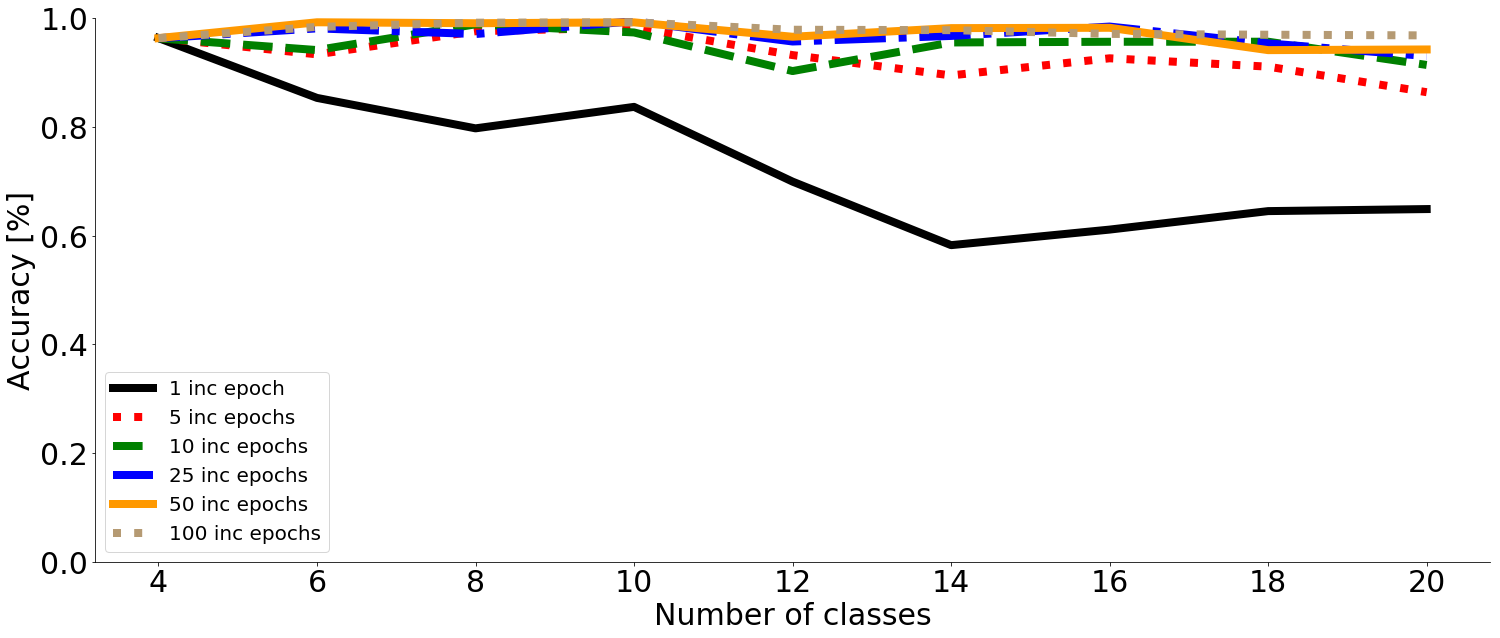

In [67]:
plots_test_curves("/mnt/Storage/code/incremental/event_based_icarl/results/big_base",
                  inc_means, inc_stds, np.arange(4, 22, 2), ["1 inc epoch", "5 inc epochs",
                                                    "10 inc epochs", "25 inc epochs",
                                                    "50 inc epochs", "100 inc epochs"])

## Experiments using small base knowledge

In [64]:
small_ext_paths = extract_subdirs("/mnt/Storage/code/incremental/event_based_icarl/results",
                                "",
                                "",
                               None)

In [65]:
_, _, _, _, total_mean_small, total_std_small = get_mean_std(small_ext_paths)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/Storage/code/incremental/event_based_icarl/results/small_base/base'